# Lab 4: The geometry of two views and 3D reconstruction

In this lab session, we are going to compute the 3D position of a pair of cameras and a set of keypoints.  For this, we will first compute correspondences between the two images.  Then, we will robustly compute the Fundamental matrix that encodes the geometry of the two views. From the Fundamental matrix and the camera calibration matrix -- that we learnt to estimate in the third lab session -- we will get the Essential matrix, which encodes the relative motion between the two cameras.  We will then compute the motion between the cameras and, finally, triangulate the matched keypoints to obtain their 3D position.

The goals of this lab assignment are the following:

- How to estimate the fundamental matrix that relates two images, corresponding to two different views of the same scene, given a set of correspondences between them. In particular, we will use the 8-point algorithm.

- How to compute the relative pose of two calibrated cameras

- How to triangulate point matches to reconstruct their 3D position.



In [3]:
import numpy as np
from numpy import linalg as LA
import cv2
import math
import sys
import random
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter

## **1. Estimation of the fundamental matrix**

### **1.1 The 8-point algorithm**

The first task is to create the function that estimates the fundamental matrix given a set of point correspondences between a pair of images. We provide the incomplete function `fundamental_matrix` that computes,
with the normalised 8-point algorithm, an estimation of the Fundamental matrix
from a set of tentative point correspondences.  

**Q1.** Complete the function `fundamental_matrix` below.

In [ ]:
# Construir epilar line, y la matrix F, la funcion de RANSAC-> calcular F.-> viene definida de la funcion.minimizar la a por la F -> hacer la minimizacion de euler. Cauler inclier-> mirar el anteiror, y saber hacer este modificarlo...Mirar el seminario.Asegurar el rango de la matriz es 2.Y solucionar.Calcular los epipolos, el left and right de la matrix para calcualr las lineas.

In [ ]:
# Segunda parte, usar la parte de lab 3, extraer el punto, la reconstrucion de las imagenes POrque falla y no.

In [45]:
def Normalization(x):

    x = np.asarray(x)
    x = x  / x[2,:]
    
    m, s = np.mean(x, 1), np.std(x)
    s = np.sqrt(2)/s;
 
    Tr = np.array([[s, 0, -s*m[0]], [0, s, -s*m[1]], [0, 0, 1]])


    xt = Tr @ x
        
    return Tr, xt

def fundamental_matrix(points1, points2):
    
    # Normalize points in both images
    T1, points1n = Normalization(points1)
    T2, points2n = Normalization(points2)

    
    p = points1n.shape[1]
    A= np.zeros([p,9])
    for i in range(p):
        x = points1n[0,i]
        y = points1n[1,i]
        x_p = points2n[0,i]
        y_p = points2n[1,i]  
        Ai = [x_p*x, x_p*y, x_p, y_p*x, y_p*y, y_p, x, y, 1]
        A[i,:] = Ai
        
#     print("A\n",A)
#     print(A.shape)
    
    # Linear solution
    U, D, Vt = np.linalg.svd(A)
    F_bar = Vt[-1,:]
    F_bar = F_bar.reshape((3, 3))
    
    # Constraint enforcement
    U, D, Vt = np.linalg.svd(F_bar)
    D[2] = 0
    D_p = np.zeros([3,3])
    np.fill_diagonal(D_p, D)
    
    F_bar_p = np.dot(U, np.dot(D_p, Vt))
#     print('Det F_bar_p:',np.linalg.det(F_bar_p))
    F = np.dot(T2.T,np.dot(F_bar_p, T1))
    
    return F



**Q2.** Why do we need to enforce the rank 2 constraint?

<mark><font size=3>**Answer:**</mark>

F is a 3x3 homogeneous matrix, with rank 2. Since it is not a full rank matrix, it implies that it is singular and its determinant is zero. In other words, since F is a 3x3 matrix but with only 2 independent rows, it is a singular matrix. 
    
We enforce the matrix F to have rank 2 constraint because it explains the mapping of a 2D plane in the 1st view to all the epipole line in the 2nd view.

Extra Notes:
The rank of a matrix is the maximum number of independent rows (or, the maximum number of independent columns). A square matrix An×n is non-singular only if its rank is equal to n.
    
Reference:https://stackoverflow.com/questions/49763903/why-does-fundamental-matrix-have-7-degrees-of-freedom

In [9]:
x1_test.shape

(3, 8)

The code below contains a toy example where we know the ground truth correspondences and ground-truth fundamental matrix. Use the code to test that the completed function is working properly.

In [36]:
# Two camera matrices for testing purposes
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1
angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
t = np.array([[.3, .1, .2]])

P2 = np.concatenate((R, t.T), axis=1)
n = 8
rand = np.random.uniform(0,1,n)
rand = rand.reshape((1, n))
rand2 = np.random.uniform(0,1,2*n)
rand2 = rand2.reshape((2, n))
ones = np.ones((1,n))
X = np.concatenate((rand2, 3*rand, ones), axis=0)

x1_test = P1 @ X
x2_test = P2 @ X

# Estimate fundamental matrix (you need to create this function)
F_es = fundamental_matrix(x1_test, x2_test)

# Ground truth fundamental matrix 
A = np.array([[0, -t[0,2], t[0,1]], [t[0,2], 0, -t[0,0]], [-t[0,1], t[0,0], 0]])
F_gt = A @ R

# Evaluation: these two matrices should be very similar
F_gt = np.sign(F_gt[0,0])*F_gt / LA.norm(F_gt)
F_es = np.sign(F_es[0,0])*F_es / LA.norm(F_es)
print(F_gt)
print(F_es)
print(LA.norm(F_gt-F_es))

Det F_bar_p: 5.080396200477704e-18
[[ 0.0978244   0.36508565 -0.18898224]
 [-0.36508565  0.0978244   0.56694671]
 [ 0.03580622 -0.59654067 -0.        ]]
[[ 9.78244040e-02  3.65085646e-01 -1.88982237e-01]
 [-3.65085646e-01  9.78244040e-02  5.66946710e-01]
 [ 3.58062170e-02 -5.96540671e-01  3.58163832e-16]]
1.1215348403348038e-14


### **1.2 Robust estimation of the fundamental matrix**

The next step is to robustly compute the Fundamental matrix from the point correspondences. For that we will use the function `ransac_fundamental_matrix` that you have to complete.

The next code computes the image correspondences.

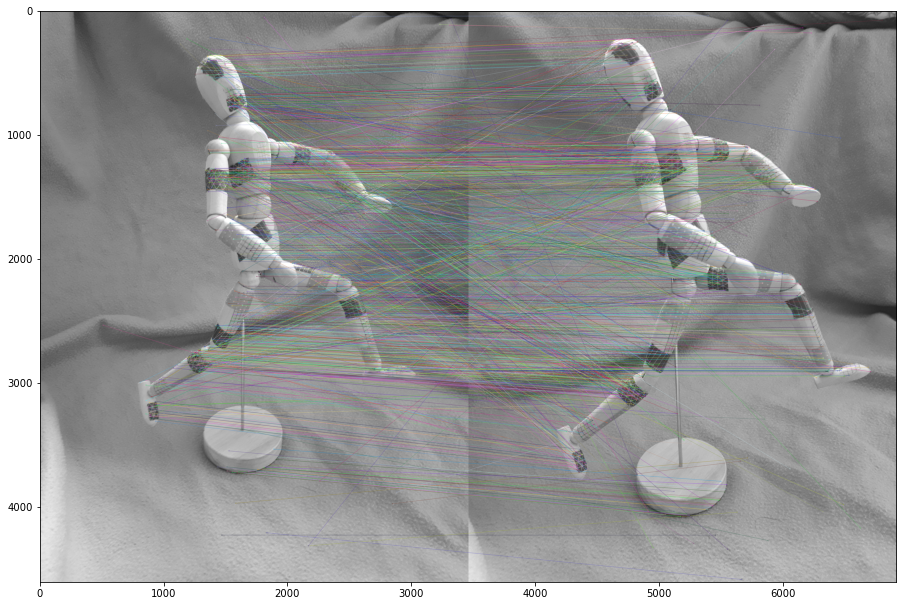

In [37]:
# Read images
img1 = cv2.imread('Data/manikin1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/manikin2.jpg',cv2.IMREAD_GRAYSCALE)

# Initiate SIFT detector
sift = cv2.SIFT_create(3000)

# find the keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1,des2)

# Show matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

**Q3.** A function `compute_inliers` is provided. How does it select the inliers? Explain also the error function used to find the inliers.

<mark><font size=3>**Answer**</mark>

it computes the distance between points in image 1 and the points in image 2 related by the fundamental matrix and take those that are lower than a certain threshold.
    

**Q4.** Complete the function `ransac_fundamental_matrix` below. Which are the missing steps that needs to be added to the function? What is the difference with the RANSAC method used in the lab 3? 

<mark><font size=3>**Answer**</mark>
    
Pasos que faltan: calcular la F para cada grupo de 8 puntos randoms, calcular los inliers que obtenemos con esa F y mirar si es el mejor modelo obtenido hasta entonces segun el numero de inliers obtenido. En ese caso, guardamos esa F como la mejor. La diferencia con el ransac method usado en el lab 3 es que usamos la F en lugar de la H y que necesitamos 8 puntos en lugar de 4 ya que ahora tenemos 8 incognitas.

In [55]:
def compute_inliers(F, x1, x2, th):
    
    Fx1 = F @ x1
    Ftx2 = F.T @ x2
    
    n = x1.shape[1]
    x2tFx1 = np.zeros((1, n))
 
    for i in range(n):
        x2t = x2[:,i]
        x2t = x2t.T
        x2tFx1[0,i] = x2t @ F @ x1[:,i]
    
    # evaluate distances
    # BUSCAR MEJOR QUE ES ESTA FORMULA
    den = Fx1[0,:]**2 + Fx1[1,:]**2 + Ftx2[0,:]**2 + Ftx2[1,:]**2
    den = den.reshape((1, n))
   
    d = x2tFx1**2 / den
    
    inliers_indices = np.where(d[0,:] < th)
    
    return inliers_indices[0]

def ransac_fundamental_matrix(points1, points2, th, max_it_0):
    
    Ncoords, Npts = points1.shape
    
    it = 0
    best_inliers = np.empty(1)
    max_it = max_it_0

    while it < max_it:
       
        indices = random.sample(range(1, Npts), 8)
        F = fundamental_matrix(points1[:, indices], points2[:, indices])
        inliers = compute_inliers(F, points1, points2, th)
        
        # test if it is the best model so far
        if (inliers.shape[0] > best_inliers.shape[0]):
            best_inliers = inliers
        
        # update estimate of iterations (the number of trials) to ensure we pick, with probability p, 
        # an initial data set with no outliers
        fracinliers = inliers.shape[0]/Npts
        pNoOutliers = 1 -  fracinliers**8
        eps = sys.float_info.epsilon
        pNoOutliers = max(eps, pNoOutliers)   # avoid division by -Inf
        pNoOutliers = min(1-eps, pNoOutliers) # avoid division by 0
        p = 0.99
        max_it = math.log(1-p)/math.log(pNoOutliers)
        if max_it > max_it_0:
            max_it = max_it_0

        it += 1
        
    # compute H from all the inliers
    F = fundamental_matrix(points1[:,best_inliers], points2[:,best_inliers])
    
    inliers = best_inliers
    
    print(it,inliers.shape[0])
    
    return F, inliers

ransac_fundamental_matrix(points1, points2, 10, 1)

1 14


(array([[ 1.18329964e-06, -3.44653534e-07, -2.29559845e-03],
        [-8.72492804e-08, -4.84826355e-08,  2.98716802e-04],
        [-1.94706152e-03,  8.47674194e-04,  3.28578928e+00]]),
 array([  4,  65, 238, 357, 370, 609, 610, 626, 627, 642, 658, 739, 768,
        966], dtype=int64))

5000 288


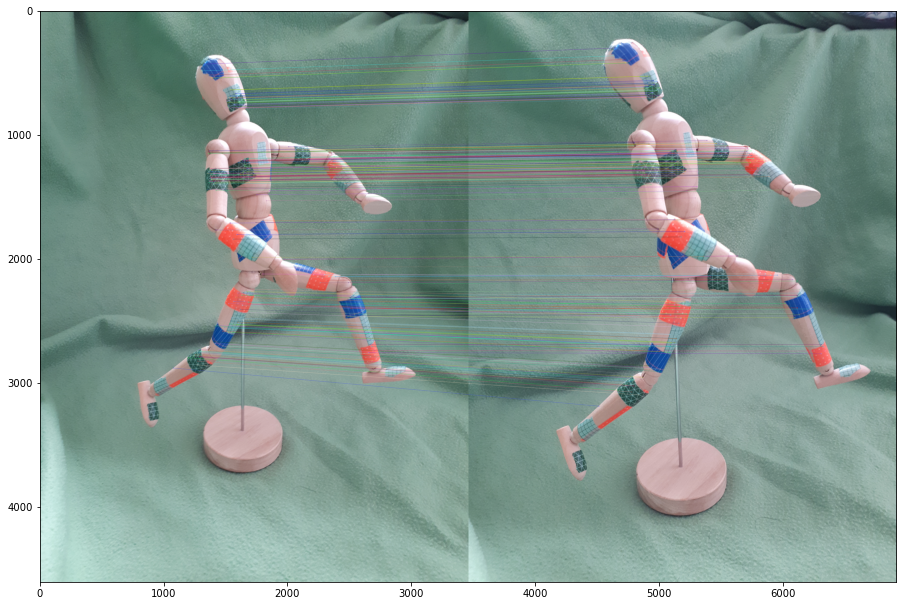

In [58]:
# Robust estimation of the fundamental matrix
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = ransac_fundamental_matrix(points1, points2, 5, 5000)
inlier_matches = itemgetter(*indices_inlier_matches)(matches)

img1 = cv2.imread('Data/manikin1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('Data/manikin2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### **1.3 Epipolar lines**

We will now visualize the epipolar lines associated to some points.

**Q5.** Choose 3 inlier points in the first image and compute their corresponding epipolar lines (in homogeneous coordinates) in the second image. Do the same but now choosing points in the second image and showing their epipolar lines in the first image. Provide the commands you used for that. The commands for showing the lines on top of the image are already provided.


**Q6.** Compute the epipoles from the Fundamental matrix. Compute the epipolar lines as the line that passes through the matching point and the epipole. Check that you obtain the same epipolar lines as before. Do the same with the images taken with your own camera during the lab session.

In [ ]:
l2 = # ... epipolar lines in image 2 
l1 = # ... epipolar lines in image 1

# choose three random indices
N = indices_inlier_matches.shape[0]
indices = random.sample(range(1, N), 3)

m1 = indices_inlier_matches[indices[0]]
m2 = indices_inlier_matches[indices[1]]
m3 = indices_inlier_matches[indices[2]]

from PIL import Image, ImageDraw, ImageOps
from utils import line_draw, plot_img

img_path = "./Data/manikin1.jpg"
I = Image.open(img_path)
I = I.rotate(-90, expand=True)
size = I.size
canv = ImageDraw.Draw(I)
line_draw(l1[:,m1], canv, size)
line_draw(l1[:,m2], canv, size)
line_draw(l1[:,m3], canv, size)
canv.ellipse((round(points1[0,m1]), round(points1[1,m1]), round(points1[0,m1])+15, round(points1[1,m1])+15), fill = 'yellow', outline ='yellow')
canv.ellipse((round(points1[0,m2]), round(points1[1,m2]), round(points1[0,m2])+15, round(points1[1,m2])+15), fill = 'yellow', outline ='yellow')
canv.ellipse((round(points1[0,m3]), round(points1[1,m3]), round(points1[0,m3])+15, round(points1[1,m3])+15), fill = 'yellow', outline ='yellow')
plt.imshow(I)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

img_path = "./Data/manikin2.jpg"
I2 = Image.open(img_path)
I2 = I2.rotate(-90, expand=True)
size = I2.size
canv2 = ImageDraw.Draw(I2)
line_draw(l2[:,m1], canv2, size)
line_draw(l2[:,m2], canv2, size)
line_draw(l2[:,m3], canv2, size)
canv2.ellipse((round(points2[0,m1]), round(points2[1,m1]), round(points2[0,m1])+15, round(points2[1,m1])+15), fill = 'yellow', outline ='yellow')
canv2.ellipse((round(points2[0,m2]), round(points2[1,m2]), round(points2[0,m2])+15, round(points2[1,m2])+15), fill = 'yellow', outline ='yellow')
canv2.ellipse((round(points2[0,m3]), round(points2[1,m3]), round(points2[0,m3])+15, round(points2[1,m3])+15), fill = 'yellow', outline ='yellow')
plt.imshow(I2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## 2. Structure computation

### **2.1 Triangulation**

Before recovering the camera motion, we will first need to implement a function to triangulate matches.  This is a function that takes as input a match and the projection matrices of two cameras, and computes the 3D position of a match.

We want then to find the 3D point $\mathbf{X}$ such that its projection onto the images are $\mathbf{x} = P \mathbf{X}$ and $\mathbf{x'} = P' \mathbf{X}$ (being $P$ and $P'$ the projection matrices of each camera).

**Q7.** Derive the system equations in the matrix form $A \mathbf{X} = \mathbf{0}$ that we need to solve in order to estimate the homogeneous coordinates of the 3D point $\mathbf{X}$.

**Q8.** Complete the code of the `triangulate`function below.

In [ ]:
def triangulate(x1, x2, P1, P2, imsize):
    
    # only one point
    if x1.ndim == 1:
        x1 = np.array([x1]).T
        x2 = np.array([x2]).T

    # number of points
    n = x1.shape[1]

    # Normalization
    x1 = x1/x1[2,:]
    x2 = x2/x2[2,:]

    nx = imsize[0];
    ny = imsize[1];

    H = [[2/nx,  0,     -1],
        [0,      2/ny,  -1],
        [0,      0,      1]]

    x1_norm = H @ x1
    x2_norm = H @ x2
    P1_norm = H @ P1
    P2_norm = H @ P2

    X = # ... complete

    return X

You may use the following test code with a toy example to validate that the `triangulate`function is working properly.

In [ ]:
# Two camera matrices for testing purposes
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1
angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
t = np.array([[.3, .1, .2]])

P2 = np.concatenate((R, t.T), axis=1)
n = 8
rand = np.random.uniform(0,1,n)
rand = rand.reshape((1, n))
rand2 = np.random.uniform(0,1,2*n)
rand2 = rand2.reshape((2, n))
ones = np.ones((1,n))
X = np.concatenate((rand2, 3*rand, ones), axis=0)

x1_test = P1 @ X
x2_test = P2 @ X

# Estimate the 3D points (you need to create this function)
x_trian = np.zeros((4, n))
x_trian = triangulate(x1_test, x2_test, P1, P2, ((2,2)));

# Evaluation: compute the reprojection error
x_eucl = x_trian / x_trian[3][np.newaxis]
X_eucl = X / X[3][np.newaxis]

diff = X_eucl - x_eucl
print(diff)

### 2.2 Relative motion between the two cameras
As seen in the theory class, the relative position between the cameras can be computed from the Essential matrix, $E$. In order to estimate $E$, we need the Fundamental matrix, $F$, that we have just computed and the camera calibration matrix, $K$, that we learnt how to estimate during the third session.

**Q9.** Compute the Essential matrix from the Fundamental matrix and the camera calibration matrix in the code below.

In [ ]:
# K matrix estimated in lab 3 (you can use this one or the one you obtained)
K = np.array([[3531.97, 9.59, 2304.33], [0, 3537.34, 1751.75], [0, 0, 1]]) 

E = # ... complete

We will assume that the first camera is at the origin, with no rotation, and that the second camera has a rotation and translation with respect to the first one.

**Q10.** Write the camera projection matrix $P$ for the first camera.

In [ ]:
P1 = # ... complete

The rotation and translation of the second camera can be computed from the SVD decomposition of $E$. There are four possible solutions.

**Q11.** Complete the code below to compute the four candidate solutions for the second camera projection matrix.

In [ ]:
U,D,VT = LA.svd(E)

# The SVD of E has several ambiguities.  In particular, U and V may be
# improper rotations in which case we need to change their sign.
if LA.det(U) < 0:
    U = -U
    
if LA.det(VT) < 0:
    VT = -VT

# four camera projection matrices for the second camera
Pc2 = np.empty(shape=(4,3,4))
Pc2[0] = # ... complete
Pc2[1] = # ... complete
Pc2[2] = # ... complete
Pc2[3] = # ... complete

from utils import plot_camera
import plotly.graph_objects as go    

ny, nx = I.size

fig = go.Figure()
plot_camera(P1, nx, ny, fig, "ref. camera")
for i in range(4):
    plot_camera(Pc2[i], nx, ny, fig, "camera2_{0}".format(i))
fig.show()

**Q12.** How can we choose the right solution from the four candidates? The code to do it is provided below, explain how it works.

In [ ]:
x1 = points1[:,indices_inlier_matches]
x2 = points2[:,indices_inlier_matches]

for P2i in Pc2:

    Xi = triangulate(x1[:,0], x2[:,0], P1, P2i, [nx, ny])
    Xi = Xi / Xi[3][np.newaxis]
    
    x1est = P1 @ Xi
    x2est = P2i @ Xi
     
    if (x1est[2] > 0) and (x2est[2] > 0):
        P2 = P2i
        break

fig = go.Figure()
plot_camera(P1, nx, ny, fig, "camera 1")
plot_camera(P2, nx, ny, fig, "camera 2")
fig.show()

### **2.3 Reconstruction from two views**

Once the proper solution for the relative motion between cameras is chosen, we can triangulate all the matches to get a sparse point cloud. 

**Q13.** Complete the code to triangulate all matches.

Use the provided code to plot the reconstructed points. If everything went fine, you should recognize the sparse points corresponding to the different parts of the manikin body at their corresponding 3D positions.

In [ ]:
# Triangulate all matches 
X = # complete ...

# Render the 3D point cloud
fig = go.Figure()
plot_camera(P1, nx, ny, fig, "camera 1")
plot_camera(P2, nx, ny, fig, "camera 2")
x_img = np.transpose(x1[:2]).astype(int)
img1 = cv2.imread('Data/manikin1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
rgb_vals = (img1[x_img[:,1], x_img[:,0]])
rgb_vals = [f'rgb{tuple(x)}' for x in rgb_vals]

point_color = [(255, 0, 0),(0,255,0)]
fig.add_trace(go.Scatter3d(x=X[0,:], y=X[2,:], z=-X[1,:], mode='markers',marker=dict(size=2,color=rgb_vals)))
fig.show()

Finally, we are going to compute the reprojection error of the reconstructed points.  This is the distance between the detected keypoints, `x1` and `x2`, and the projection of the reconstructed points.

**Q14.** Complete the code to compute the reprojection error of each match. Plot the histogram of the errors with the provided code.

In [ ]:
def reprojection_errors(x1,x2,P1,P2,X):
    
    # ... complete


err = reprojection_errors(x1,x2,P1,P2,X)
plt.hist(err,bins='auto')
err_mean = np.mean(err)
print(f'Mean reprojection error: {err_mean}')

**Q15.** Repeat all the process with your own images taken with your
camera. Try reconstructions for different pairs of images and comment the results
obtained.